# ConvKAN + CIFAR10
Purpose: Fit a ConvKAN to the CIFAR10 dataset.

This is the Accuracy variant, which means it seeks to find the highest performance using as much of the dataset as possible, while balancing the parameter count.

Furthermore, the PyTorch Lightning library is used for convenience.

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch
from torch import nn
import lightning as L
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

import sys
sys.path.append('convkans/kan_convolutional')
from KANLinear import *
from KANConv import KAN_Convolutional_Layer

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup Randomness -- https://lightning.ai/docs/pytorch/stable/common/trainer.html
L.seed_everything(1000000007, workers=True) # <--- Adjust the seed here for each trial run for the 5 seed values [42, 998244353, 10122024, 1000000007, 68812].

# CUDA Efficiency
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')
    print("Configured CUDA Precision")

Seed set to 1000000007


Configured CUDA Precision


In [2]:
# Dataset Setup -- Inspired by Hugo's Dataset Reformatting
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CIFAR10("./Experiments/temp/", train=True, download=True, transform=transform)
test_dataset = CIFAR10("./Experiments/temp/", train=False, download=True, transform=transform)

train_size = int(len(train_dataset) * 0.90)
val_size = int(len(train_dataset)) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Reformatted, due to odd issues when using NTK on it
class LCDataset(Dataset): # Lightning Compatible Dataset
    def __init__(self, dataset, num_classes, limit=-1):
        self.limit = limit
        self.num_classes = num_classes
        if self.limit != -1:
            sub = list(np.random.permutation(np.arange(len(dataset)))[0:self.limit]) # Take a random sample of the first some elements.
            self.dataset = Subset(dataset, sub)
        else:
            self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y_one_hot = torch.zeros(self.num_classes)
        y_one_hot[y] = 1
        return x, y_one_hot

batch_size = 64
train_loader = DataLoader(LCDataset(train_set, num_classes=10), batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = DataLoader(LCDataset(val_set, num_classes=10), batch_size=batch_size, shuffle=False, num_workers=10)
test_loader = DataLoader(LCDataset(test_dataset, num_classes=10), batch_size=batch_size, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Model Declaration
class NetConvKAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(3),
            KAN_Convolutional_Layer(in_channels=3, out_channels=16, kernel_size=(2, 2), grid_size=2, spline_order=2, device=device),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.GELU(),
            nn.Flatten(1),
            nn.Dropout(p=0.50),
            nn.Linear(3600, 64, bias=False),
            nn.GELU(),
            nn.Dropout(p=0.50),
            nn.Linear(64, 10, bias=False)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        loss = F.cross_entropy(y_pred, y)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True) # Observe model accuracy with time

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("accuracy", accuracy) # Accuracy for Accuracy vs. Parameter Experiment

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [4]:
# Train + Test + Results
model = NetConvKAN()
trained_model = L.Trainer(max_epochs=10, deterministic=True, logger=CSVLogger(save_dir="Experiments/logs", name="CIFAR10ConvKANAcc", version="fin"), callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)])
trained_model.fit(model, train_loader, val_loader)
trained_model.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 232 K  | train
--------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.929     Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.5907999873161316     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.5907999873161316}]

In [5]:
logdata = pd.read_csv("Experiments/logs/CIFAR10ConvKANAcc/fin/metrics.csv")

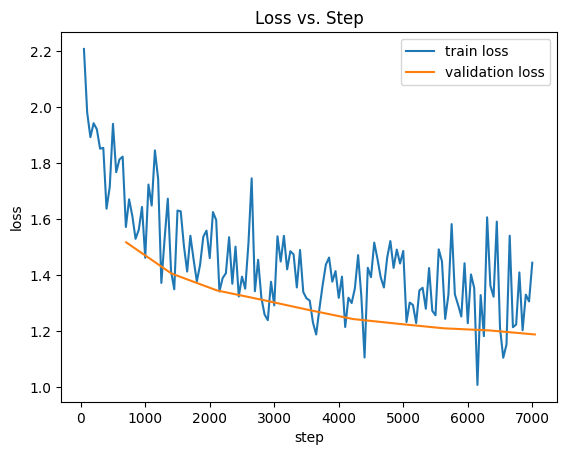

In [6]:
traindeflog = logdata.loc[logdata['train_loss'].notna(), ['step', 'train_loss']]
valdeflog = logdata.loc[logdata['val_loss'].notna(), ['step', 'val_loss']]
fig, ax = plt.subplots()
ax.plot(traindeflog['step'], traindeflog['train_loss'], label="train loss")
ax.plot(valdeflog['step'], valdeflog['val_loss'], label="validation loss")
ax.set(xlabel="step", ylabel="loss", title="Loss vs. Step")
plt.legend(loc="upper right")
plt.show()

In [7]:
# R: True Value, C: Predicted Value
def make_predict_matrix(model, dataloader):
    res = np.zeros(shape=(10, 10), dtype=int)
    model = model.to(device)
    for it in iter(dataloader):
        x, y = it
        x = x.to(device)
        y = y.to(device)
        x_arg = torch.argmax(model.forward(x), dim=1)
        y_arg = torch.argmax(y, dim=1)
        for i in range(len(x_arg)):
            res[y_arg[i], x_arg[i]] += 1
    return res

In [8]:
print(make_predict_matrix(model, test_loader))

[[558  59  75  14  17  13  30  25 167  42]
 [ 41 666  14  11   3   7  18  22  73 145]
 [ 75  26 370  50 123 105 126  66  33  26]
 [ 30  37  90 242  64 236 148  72  33  48]
 [ 41  20 162  52 328  93 150 124  21   9]
 [ 14  17  80 138  40 477  65 124  20  25]
 [ 15  23  81  57  56  38 673  37  10  10]
 [ 25  23  33  59  60 121  46 573   6  54]
 [106  86  16  15   6  16  10   8 677  60]
 [ 42 207   9  16   3  22  29  50  59 563]]
